<b>Name : Tejas Karimanne Indushekar</b><br/>

In [0]:
import pandas as pd
import urllib
import numpy as np
import os
import sys
import requests
from bs4 import BeautifulSoup
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.validation import check_X_y
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')
import seaborn as sns

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## TASK 1

I have made use of beautiful soup for web scrapping of the data

In [0]:
url = "http://mlg.ucd.ie/modules/yalp/"
# Below i am first making the request to get the URL of the home page
content_page = requests.get(url).content
# Creating a parser to access all the elements of the page
soup = BeautifulSoup(content_page,"html.parser")
# Finding all the h4 elements since the category was defined as h4
category = soup.find_all('h4')
# looping all the categories to get further data
for cat in category:
  category_title = cat.find("a").get_text()
# I have selected Categories Cafes,Fashion and Hotels to be used
  if category_title not in ["Category: Cafes","Category: Fashion","Category: Hotels"]:
    continue
# Creating a parser to access all the elements of the category page
  link_1 = url+cat.find("a").get('href')
  cat_page = requests.get(link_1).content
  cat_page_soup = BeautifulSoup(cat_page,"html.parser")
# Finding all the h5 elements since the each of the units were defined as h5
  units = cat_page_soup.find_all('h5')
  each_category = []
  #df2 = pd.DataFrame()
# looping all the units to get further data
  for unit in units:
    link_2 = url+unit.find("a").get('href')
    link_2_page = requests.get(link_2).content
# Creating a parser to access all the elements of the unit page
    link_2_soup = BeautifulSoup(link_2_page,"html.parser")
# Finding all the elements whose class is review to extract the reviews data
    reviews = link_2_soup.find_all(class_='review')
# looping through all the reviews to get the required data
    for review in reviews:
# Finding all the elements whose class is review-text to extract the reviews written
      review_text = review.find(class_='review-text').get_text()
      rating = review.find(class_='rating').find('img').get('alt')
      rating = rating.split("-")[0]
      rating = int(rating)
      rating_data = []
# Extracting and storing review text      
      rating_data.append(review_text)    
# Extracting and storing label based on the ratings (0-3 = Negative >3 = Positive)        
      if rating <= 3:
        rating_data.append("Negative")
      else:
        rating_data.append("Positive")
      #df2 = df2.append('\n')
      each_category.append(rating_data)
      #each_category.append("\n") 
      #print(each_category)
# Storing the category title as category_'category name'      
  category_title = "category_"+category_title.split(":")[-1].replace(" ","").lower()
# creating a data frame of each category and storing them as a csv file  
  df = pd.DataFrame(each_category,columns=['review_text','label'])
  df.to_csv(category_title+'.csv',index=False)

## **Task 2**

### **Data Pre-Procesing**

Reading the csv files generated and creating a saperate dataframe for each of the categories and selecting the data and label for the classification.

In [0]:
df_cafes = pd.read_csv("category_cafes.csv")
review_category_1 = df_cafes.review_text
label_category_1 = df_cafes.label

df_fashion = pd.read_csv("category_fashion.csv")
review_category_2 = df_fashion.review_text
label_category_2 = df_fashion.label

df_hotels = pd.read_csv("category_hotels.csv")
review_category_3 = df_hotels.review_text
label_category_3 = df_hotels.label

Data Pre-Processing plays a very important role in building a Classifier. Below a function has been defined to take care of tokenization and lemmatization. This function helps us in converting into tokens and convert them to their root forms. I have also set a parmeter during lemmatization to account it as a verb since we are dealing with reviews and i believe most of the words used will be  to express something.

In [0]:
def lemma_tokenizer(text):
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma_tokens = []
    for token in tokens:
        lemma_tokens.append(lemmatizer.lemmatize(token,'v'))
    return lemma_tokens

I have used the built in tfidf vectorizer to remove stop words, take in to account ngrams and to consider tokens that appear atleast 5 times. Values for min_df and ngram_range has been set by doing trial and error. ngram of size 2 made more sense than any other size, analysis for the same can be seen further below.  

In [0]:
import warnings
warnings.simplefilter("ignore")
vectorizer_category_1 = TfidfVectorizer(tokenizer=lemma_tokenizer,stop_words="english",min_df=5,ngram_range = (2,2))
X_category_1 = vectorizer_category_1.fit_transform(review_category_1)
vectorizer_category_2 = TfidfVectorizer(tokenizer=lemma_tokenizer,stop_words="english",min_df=5,ngram_range = (2,2))
X_category_2 = vectorizer_category_2.fit_transform(review_category_2)
vectorizer_category_3 = TfidfVectorizer(tokenizer=lemma_tokenizer,stop_words="english",min_df=5,ngram_range = (2,2))
X_category_3 = vectorizer_category_3.fit_transform(review_category_3)

Checking for the most frequent terms for Category 1 (Cafes)

I am displaying the most frequent words and also using the word cloud, the reason for this is since i have used ngram of (2,2) the top 10 words displayed takes into account the ngrams and displays words frequented in couples, and the word cloud displayed helps us understand the most individual frequented words.

ice cream = 31.05
coffee shop = 28.97
customer service = 24.04
great place = 22.16
love place = 20.20
highly recommend = 19.17
really good = 18.92
pretty good = 17.37
great food = 17.26
staff friendly = 16.93





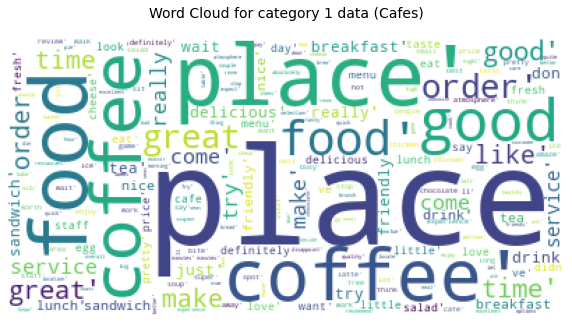

In [0]:
terms_1 = vectorizer_category_1.get_feature_names()
freqs_1 = X_category_1.sum(axis=0)
sorted_term_indexes = freqs_1.argsort()
sorted_term_indexes = sorted_term_indexes[0, ::-1]
for i in range(10):
    term_index = sorted_term_indexes[0,i]
    print("%s = %.2f" % (terms_1[term_index], freqs_1[0,term_index]))
print('\n\n')
terms_1_wc = WordCloud(background_color ='white').generate(str(terms_1)) 
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(terms_1_wc) 
plt.title("Word Cloud for category 1 data (Cafes)", fontsize=14,pad = 20)
plt.axis("off")
plt.show() 

Checking for the most frequent terms for Category 2 (Fashion)

customer service = 74.98
staff friendly = 22.43
highly recommend = 19.53
make sure = 18.00
feel like = 16.86
great selection = 16.38
sales associate = 16.09
don know = 15.44
look like = 14.33
shop experience = 14.00





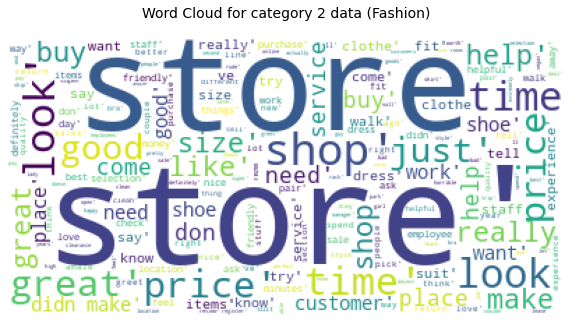

In [0]:
terms_2 = vectorizer_category_2.get_feature_names()
freqs_2 = X_category_2.sum(axis=0)
sorted_term_indexes = freqs_2.argsort()
sorted_term_indexes = sorted_term_indexes[0, ::-1]
for i in range(10):
    term_index = sorted_term_indexes[0,i]
    print("%s = %.2f" % (terms_2[term_index], freqs_2[0,term_index]))
print('\n\n')
terms_2_wc = WordCloud(background_color ='white').generate(str(terms_2)) 
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(terms_2_wc) 
plt.title("Word Cloud for category 2 data (Fashion)", fontsize=14,pad = 20)
plt.axis("off")
plt.show() 

Checking for the most frequent terms for Category 3 (Hotels)

customer service = 51.04
highly recommend = 32.42
make sure = 23.63
room clean = 21.56
staff friendly = 19.11
rent car = 18.09
great experience = 15.15
feel like = 14.99
las vegas = 14.36
car rental = 13.73





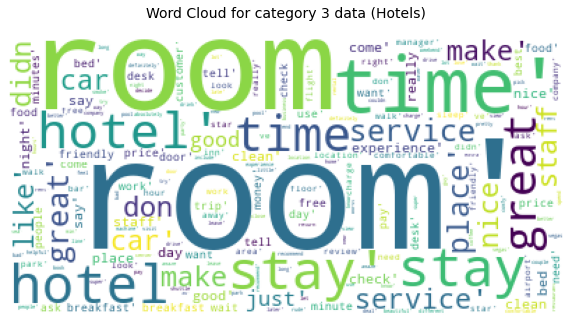

In [0]:
terms_3 = vectorizer_category_3.get_feature_names()
freqs_3 = X_category_3.sum(axis=0)
sorted_term_indexes = freqs_3.argsort()
sorted_term_indexes = sorted_term_indexes[0, ::-1]
for i in range(10):
    term_index = sorted_term_indexes[0,i]
    print("%s = %.2f" % (terms_3[term_index], freqs_3[0,term_index]))
print('\n\n')
terms_3_wc = WordCloud(background_color ='white').generate(str(terms_3)) 
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(terms_3_wc) 
plt.title("Word Cloud for category 3 data (Hotels)", fontsize=14,pad = 20)
plt.axis("off")
plt.show() 

From all the above we can see, wordcloud gives us more single words which are frequented but the displayed words which takes in to account ngrams, we can see that it makes more sense as a review.

### **Classification Model**

### Naive Bayes Model for category 1 (Cafes)

Splitting the data into test and training set. I have considered 20% as test set and 80% as training set

In [0]:
data_train_1, data_test_1, label_train_1, label_test_1 = train_test_split(X_category_1, label_category_1, test_size=0.2)

Creating a Naive Bayes classification Model. Though Naive Bayes assumes features are independent, with text classification it performs very well. I also considered Gaussian model but the accuracy dropped to a very low score, hence i am creating a model on Multinomial Naive Bayes.

In [0]:
#from sklearn.naive_bayes import GaussianNB
#model_nb_1 = GaussianNB()
model_nb_1 = MultinomialNB()
model_nb_1.fit(data_train_1,label_train_1)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Predicting the test set for the model

In [0]:
nb_predict_1 = model_nb_1.predict(data_test_1)

Overall accuracy of the model:

In [0]:
accuracy_nb_1 = accuracy_score(label_test_1,nb_predict_1)
print("Accuracy = %.2f" % accuracy_nb_1 )

Accuracy = 0.82


The below helps us understand the labels and we can see that the label 'Positive' are high in number compared to 'Negative', which shows that this is a imbalanced data.

In [0]:
df_cafes.groupby(['label']).agg(pd.Series.count)

,review_text
label,
Negative,538
Positive,1462


Confusion Matrix

Below confusion matrix helps us understand how well the classifer is working and where the errors are. Like we saw the data is imbalanced, here we can see true positives are significantly more than true negatives.

Text(33.0, 0.5, '')

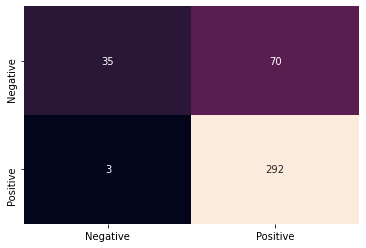

In [0]:
confusion_matrix_1 =  pd.crosstab(label_test_1, nb_predict_1)
plot_1 = sns.heatmap(confusion_matrix_1,annot=True,cbar=False,fmt='d')  
plt.xlabel("") 
plt.ylabel("")

Complete summary of the model

Classification report gives complete statistics of the model. Closer the f1 score to 1 the better, we see the f1 score for positive is higher than that of negative, this is also because the data is imbalanced and the same can be seen in support. The overall accuracy is around 82% which is not bad.

In [0]:
print(classification_report(label_test_1, nb_predict_1))

              precision    recall  f1-score   support

    Negative       0.92      0.33      0.49       105
    Positive       0.81      0.99      0.89       295

    accuracy                           0.82       400
   macro avg       0.86      0.66      0.69       400
weighted avg       0.84      0.82      0.78       400



Cross Validation

For evaluation cross validation provides a appropriate accuracy which can be taken into consideration. The advantage of cross validation is that all features are used for both training and validation, and each observation is used for validation exactly once. I have made use of 10-fold cross validation.

In [0]:
cross_validation_score_1 = cross_val_score(model_nb_1, X_category_1, label_category_1, cv=10, scoring="accuracy")
print(cross_validation_score_1)
Mean_accuracy_1 = cross_validation_score_1.mean()
print("Mean Accuracy = %.2f" % Mean_accuracy_1)

[0.75  0.74  0.765 0.785 0.795 0.805 0.795 0.735 0.81  0.835]
Mean Accuracy = 0.78


### Naive Bayes Model for category 2 (Fashion)

Splitting the 2nd category data into test and training set. I have considered 20% as test set and 80% as training set

In [0]:
data_train_2, data_test_2, label_train_2, label_test_2 = train_test_split(X_category_3, label_category_2, test_size=0.2)

Building a Naive Bayes classification Model.

In [0]:
model_nb_2 = MultinomialNB()
model_nb_2.fit(data_train_2,label_train_2)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Predicting the test set for the model

In [0]:
nb_predict_2 = model_nb_2.predict(data_test_2)

Overall accuracy of the model:

In [0]:
accuracy_nb_2 = accuracy_score(label_test_2,nb_predict_2)
print("Accuracy = %.2f" % accuracy_nb_2 )

Accuracy = 0.58


The below helps us understand the labels and we can see that the label 'Positive' are high in number compared to 'Negative', which shows that this is a imbalanced data.

In [0]:
df_fashion.groupby(['label']).agg(pd.Series.count)

,review_text
label,
Negative,795
Positive,1205


Confusion Matrix

Below confusion matrix helps us understand how well the classifer is working and where the errors are. Like we saw the data is imbalanced, here we can see true positives are significantly more than true negatives.

Text(33.0, 0.5, '')

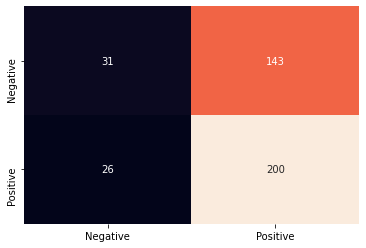

In [0]:
confusion_matrix_2 = pd.crosstab(label_test_2, nb_predict_2,)
plot_1 = sns.heatmap(confusion_matrix_2,annot=True,cbar=False,fmt='d')  
plt.xlabel("") 
plt.ylabel("")

Complete summary of the model

Classification report gives complete statistics of the model. We see the f1 score for positive is higher than that of negative, this is also because the data is imbalanced and the same can be seen in support. The overall accuracy is around 58%.

In [0]:
print(classification_report(label_test_2, nb_predict_2))

              precision    recall  f1-score   support

    Negative       0.54      0.18      0.27       174
    Positive       0.58      0.88      0.70       226

    accuracy                           0.58       400
   macro avg       0.56      0.53      0.49       400
weighted avg       0.57      0.58      0.51       400



Cross Validation

For evaluation cross validation provides a appropriate accuracy which can be taken into consideration. I have made use of 10-fold cross validation. Here we can observe that there is a significant difference in overall accuracy compared to Mean accuracy of the cross validation method.

In [0]:
cross_validation_score_2 = cross_val_score(model_nb_2, X_category_2, label_category_2, cv=10, scoring="accuracy")
print(cross_validation_score_2)
Mean_accuracy_2 = cross_validation_score_2.mean()
print("Mean Accuracy = %.2f" % Mean_accuracy_2)

[0.74  0.765 0.735 0.78  0.76  0.73  0.765 0.755 0.78  0.8  ]
Mean Accuracy = 0.76


### Naive Bayes Model for category 3 (Hotels)

Splitting the 3rd category data into test and training set. I have considered 20% as test set and 80% as training set

In [0]:
data_train_3, data_test_3, label_train_3, label_test_3 = train_test_split(X_category_3, label_category_3, test_size=0.2)

Building a Naive Bayes classification Model.

In [0]:
model_nb_3 = MultinomialNB()
model_nb_3.fit(data_train_3,label_train_3)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Predicting the test set for the model

In [0]:
nb_predict_3 = model_nb_3.predict(data_test_3)

Overall accuracy of the model:

In [0]:
accuracy_nb_3 = accuracy_score(label_test_3,nb_predict_3)
print("Accuracy = %.2f" % accuracy_nb_3 )

Accuracy = 0.84


The below helps us understand the labels and we can see that the label 'Positive' are high in number compared to 'Negative', which shows that this is a imbalanced data.

In [0]:
df_hotels.groupby(['label']).agg(pd.Series.count)

,review_text
label,
Negative,824
Positive,1176


Confusion Matrix

Unlike the previous models we can see there is no significant difference between true positive and true negative, and also the errors are low compared to previous ones.

Text(33.0, 0.5, '')

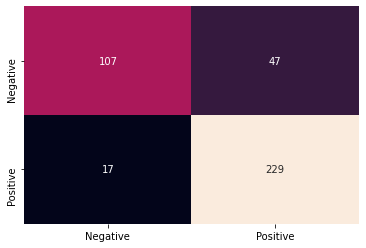

In [0]:
confusion_matrix_3 = pd.crosstab(label_test_3, nb_predict_3)
plot_3 = sns.heatmap(confusion_matrix_3,annot=True,cbar=False,fmt='d')  
plt.xlabel("") 
plt.ylabel("")

Complete summary of the model

Classification report gives complete statistics of the model. We see the f1 score for positive and negative are in similar range. The overall accuracy is around 84% which is not bad. Though data is imbalanced, from f1 score we can see that this model does a good job in predicting both the classes.

In [0]:
print(classification_report(label_test_3, nb_predict_3))

              precision    recall  f1-score   support

    Negative       0.86      0.69      0.77       154
    Positive       0.83      0.93      0.88       246

    accuracy                           0.84       400
   macro avg       0.85      0.81      0.82       400
weighted avg       0.84      0.84      0.84       400



Cross Validation

Overall accuracy and the mean accuracy are very similar for this model.

In [0]:
cross_validation_score_3 = cross_val_score(model_nb_3, X_category_3, label_category_3, cv=10, scoring="accuracy")
print(cross_validation_score_3)
Mean_accuracy_3 = cross_validation_score_3.mean()
print("Mean Accuracy = %.2f" % Mean_accuracy_3)

[0.845 0.735 0.77  0.86  0.815 0.775 0.755 0.8   0.79  0.725]
Mean Accuracy = 0.79


### Cross validation mean accuracy comparison for all the three models of Task 2

Since cross validation provides a more accuracte score. We see that Mean accuracy for all the three models are in the same range.

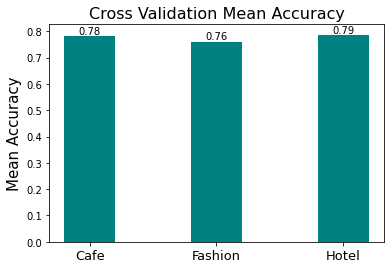

In [0]:
values = [Mean_accuracy_1, Mean_accuracy_2, Mean_accuracy_3]
names = ["Cafe","Fashion","Hotel"]
plt_mean_accu = plt.bar(names, values, color="teal", width=0.4)
plt.xticks(fontsize=13)
plt.ylabel("Mean Accuracy", fontsize=15)
plt.title("Cross Validation Mean Accuracy", fontsize=16)
# function to auto label each of the bar values
def autolabel(plot_label_func):
    for lbl in plot_label_func:
        height = lbl.get_height()
        plt.text(lbl.get_x() + lbl.get_width()/2, 1*height,'%.2f' % float(height),ha='center', va='bottom')
autolabel(plt_mean_accu)

The mean accuracy for all the three models are nearly the same with hotels having the highest of 79% and fashion has the least with 76%

## **Task 3**

During vectorization the features are generated based on the data used to fit and transform. When we use data from a different category to predict, there will be a dimension mismatch. Hence i am using the appropriate vectorization of the model to tranform the data we are trying to predict.

### Naive Bayes Model for category 1 (Cafes) evaluated on category 2 (Fashion) and category 3 (Hotels)

Building a Naive Bayes classification Model and using Category 1 data to train.

In [0]:
#X_category_1_1 = vectorizer_category_1.transform(review_category_1)
model_nb_1_cafes = MultinomialNB()
model_nb_1_cafes.fit(X_category_1,label_category_1)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Transforming the data from category 2 and 3 using the vectorizer of category 1

In [0]:
#nb_predict_cafes_fashion = model_nb_1_cafes.predict(X_category_2)
X_1_2 = vectorizer_category_1.transform(review_category_2)
X_1_3 = vectorizer_category_1.transform(review_category_3)

In [0]:
print(X_category_1.shape)
print(X_1_2.shape)
print(X_1_3.shape)

(2000, 1305)
(2000, 1305)
(2000, 1305)


Predicting the model for category 2 and 3 data

In [0]:
nb_predict_cafes_fashion = model_nb_1_cafes.predict(X_1_2)
nb_predict_cafes_hotels = model_nb_1_cafes.predict(X_1_3)

Evaluation for category 2 (fashion)

Accuracy for Category 2 data (fashion) = 0.68



classification report for category 2
              precision    recall  f1-score   support

    Negative       0.74      0.28      0.41       795
    Positive       0.66      0.94      0.78      1205

    accuracy                           0.68      2000
   macro avg       0.70      0.61      0.59      2000
weighted avg       0.70      0.68      0.63      2000






Text(33.0, 0.5, '')

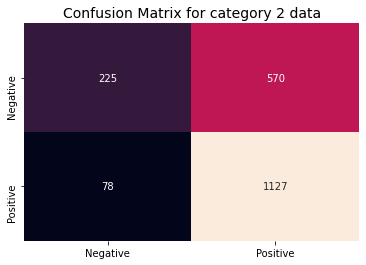

In [0]:
accuracy_1_2 = accuracy_score(nb_predict_cafes_fashion,label_category_2)
print("Accuracy for Category 2 data (fashion) = %.2f" % accuracy_1_2 )

print("\n\n")
print("classification report for category 2")
print(classification_report(label_category_2, nb_predict_cafes_fashion))
report_1_2 = classification_report(label_category_2, nb_predict_cafes_fashion,output_dict=True)
print("\n\n")
confusion_matrix_1_2 = pd.crosstab(label_category_2, nb_predict_cafes_fashion )
plot_1_2 = sns.heatmap(confusion_matrix_1_2,annot=True,cbar=False,fmt='d')   
plt.title('Confusion Matrix for category 2 data', fontsize = 14) 
plt.xlabel("") 
plt.ylabel("")

From the above, confusion matrix helps us understand how well the classifer is working and where the errors are. Here we can see true positives are significantly more than true negatives also f1 scores for positive and negative have huge difference ,which might be because of the data imbalance.

Evaluation for category 3 (hotels)

Accuracy for category 3 data (hotels) = 0.67



classification report for category 3
              precision    recall  f1-score   support

    Negative       0.81      0.27      0.41       824
    Positive       0.65      0.95      0.77      1176

    accuracy                           0.67      2000
   macro avg       0.73      0.61      0.59      2000
weighted avg       0.71      0.67      0.62      2000






Text(33.0, 0.5, '')

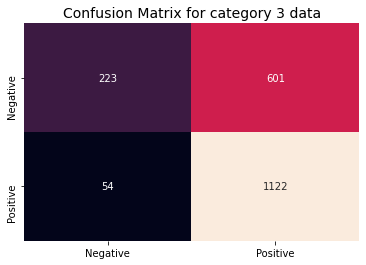

In [0]:
accuracy_1_3 = accuracy_score(nb_predict_cafes_hotels,label_category_3)
print("Accuracy for category 3 data (hotels) = %.2f" % accuracy_1_3 )

print("\n\n")
print("classification report for category 3")
print(classification_report(label_category_3, nb_predict_cafes_hotels))
report_1_3 = classification_report(label_category_3, nb_predict_cafes_hotels,output_dict=True)
print("\n\n")
confusion_matrix_1_3 = pd.crosstab(label_category_3, nb_predict_cafes_hotels)
plot_1_3 = sns.heatmap(confusion_matrix_1_3,annot=True,cbar=False,fmt='d')  
plt.title('Confusion Matrix for category 3 data', fontsize = 14) 
plt.xlabel("") 
plt.ylabel("")

From the above, confusion matrix  we can see true positives are significantly more than true negatives also f1 scores for positive and negative have huge difference ,which might be because of the data imbalance.

### Naive Bayes Model for category 2 (fashion) evaluated on category 1 (Fashion) and category 3 (Hotels)



Building a Naive Bayes classification Model and using Category 2 data to train.

In [0]:
model_nb_2_fashion = MultinomialNB()
model_nb_2_fashion.fit(X_category_2,label_category_2)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Transforming the data from category 1 and 3 using the vectorizer of category 2

In [0]:
X_2_1 = vectorizer_category_2.transform(review_category_1)
X_2_3 = vectorizer_category_2.transform(review_category_3)

In [0]:
print(X_category_2.shape)
print(X_2_1.shape)
print(X_2_3.shape)

(2000, 1315)
(2000, 1315)
(2000, 1315)


Predicting the model for category 1 and 3 data

In [0]:
nb_predict_fashion_cafes = model_nb_2_fashion.predict(X_2_1)
nb_predict_fashion_hotels = model_nb_2_fashion.predict(X_2_3)

Evaluation for category 1 data (cafes)


Accuracy for Category 1 data (cafes) = 0.78



classification report for category 1 data
              precision    recall  f1-score   support

    Negative       0.69      0.37      0.48       538
    Positive       0.80      0.94      0.86      1462

    accuracy                           0.78      2000
   macro avg       0.74      0.65      0.67      2000
weighted avg       0.77      0.78      0.76      2000






Text(33.0, 0.5, '')

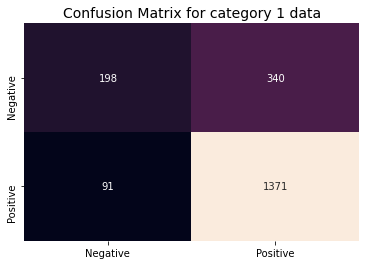

In [0]:
accuracy_2_1 = accuracy_score(nb_predict_fashion_cafes,label_category_1)
print("Accuracy for Category 1 data (cafes) = %.2f" % accuracy_2_1 )

print("\n\n")
print("classification report for category 1 data")
print(classification_report(label_category_1, nb_predict_fashion_cafes))
report_2_1 = classification_report(label_category_1, nb_predict_fashion_cafes,output_dict=True)
print("\n\n")
confusion_matrix_2_1 = pd.crosstab(label_category_1, nb_predict_fashion_cafes)
plot_2_1 = sns.heatmap(confusion_matrix_2_1,annot=True,cbar=False,fmt='d') 
plt.title('Confusion Matrix for category 1 data', fontsize = 14) 
plt.xlabel("") 
plt.ylabel("")

From the above confusion matrix  we can see true positives are significantly more than true negatives also f1 scores for positive and negative have huge difference which is an effect of imbalanced data

Evaluation for category 3 data (hotels)

Accuracy for category 3 (hotels) = 0.74



classification report for category 3 data
              precision    recall  f1-score   support

    Negative       0.81      0.47      0.60       824
    Positive       0.71      0.92      0.81      1176

    accuracy                           0.74      2000
   macro avg       0.76      0.70      0.70      2000
weighted avg       0.75      0.74      0.72      2000






Text(33.0, 0.5, '')

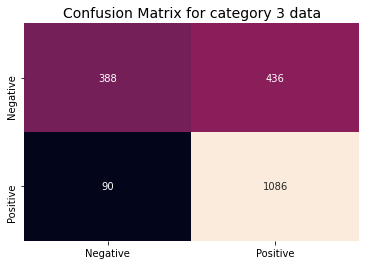

In [0]:
accuracy_2_3 = accuracy_score(nb_predict_fashion_hotels,label_category_3)
print("Accuracy for category 3 (hotels) = %.2f" % accuracy_2_3 )

print("\n\n")
print("classification report for category 3 data")
print(classification_report(label_category_3, nb_predict_fashion_hotels))
report_2_3 = classification_report(label_category_3, nb_predict_fashion_hotels,output_dict=True)
print("\n\n")
confusion_matrix_2_3 = pd.crosstab(label_category_3, nb_predict_fashion_hotels)
plot_2_3 = sns.heatmap(confusion_matrix_2_3,annot=True,cbar=False,fmt='d')  
plt.title('Confusion Matrix for category 3 data', fontsize = 14) 
plt.xlabel("") 
plt.ylabel("")

### Naive Bayes Model for category 3 (hotels) evaluated on category 1 (Fashion) and category 2 (fashion)

Building a Naive Bayes classification Model and using Category 3 data to train.

In [0]:
model_nb_3_hotels = MultinomialNB()
model_nb_3_hotels.fit(X_category_3,label_category_3)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Transforming the data from category 1 and 2 using the vectorizer of category 3

In [0]:
X_3_1 = vectorizer_category_3.transform(review_category_1)
X_3_2 = vectorizer_category_3.transform(review_category_2)

In [0]:
print(X_category_3.shape)
print(X_3_1.shape)
print(X_3_2.shape)

(2000, 1412)
(2000, 1412)
(2000, 1412)


Predicting the model for category 1 and 2 data


In [0]:
nb_predict_hotels_cafes = model_nb_3_hotels.predict(X_3_1)
nb_predict_hotels_fashion = model_nb_3_hotels.predict(X_3_2)

Evaluation for category 1 data (cafes)

Accuracy for Category 1 data (cafes) = 0.79



classification report for category 1 data
              precision    recall  f1-score   support

    Negative       0.68      0.43      0.53       538
    Positive       0.82      0.93      0.87      1462

    accuracy                           0.79      2000
   macro avg       0.75      0.68      0.70      2000
weighted avg       0.78      0.79      0.78      2000






Text(33.0, 0.5, '')

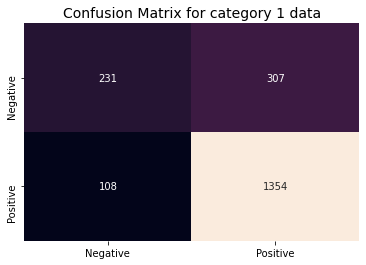

In [0]:
accuracy_3_1 = accuracy_score(nb_predict_hotels_cafes,label_category_1)
print("Accuracy for Category 1 data (cafes) = %.2f" % accuracy_3_1 )

print("\n\n")
print("classification report for category 1 data")
print(classification_report(label_category_1, nb_predict_hotels_cafes))
report_3_1 = classification_report(label_category_1, nb_predict_hotels_cafes,output_dict=True)
print("\n\n")
confusion_matrix_3_1 = pd.crosstab(label_category_1, nb_predict_hotels_cafes)
plot_3_1 = sns.heatmap(confusion_matrix_3_1,annot=True,cbar=False,fmt='d')  
plt.title('Confusion Matrix for category 1 data', fontsize = 14) 
plt.xlabel("") 
plt.ylabel("")

Evaluation for category 2 data (fashion)


Accuracy for category 3 (hotels) = 0.74



classification report for category 3 data
              precision    recall  f1-score   support

    Negative       0.71      0.57      0.63       795
    Positive       0.75      0.85      0.80      1205

    accuracy                           0.74      2000
   macro avg       0.73      0.71      0.71      2000
weighted avg       0.73      0.74      0.73      2000






Text(33.0, 0.5, '')

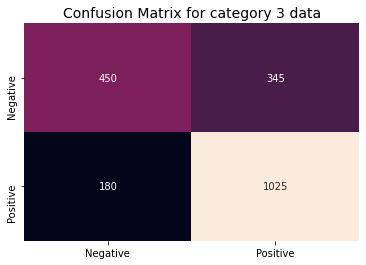

In [0]:
accuracy_3_2 = accuracy_score(nb_predict_hotels_fashion,label_category_2)
print("Accuracy for category 3 (hotels) = %.2f" % accuracy_3_2 )

print("\n\n")
print("classification report for category 3 data")
print(classification_report(label_category_2, nb_predict_hotels_fashion))
report_3_2 = classification_report(label_category_2, nb_predict_hotels_fashion,output_dict=True)
print("\n\n")
confusion_matrix_3_2 = pd.crosstab(label_category_2,nb_predict_hotels_fashion)
plot_3_2 = sns.heatmap(confusion_matrix_3_2,annot=True,cbar=False,fmt='d') 
plt.title('Confusion Matrix for category 3 data', fontsize = 14) 
plt.xlabel("") 
plt.ylabel("")

### Comparing the overall accuracy of all the above three models for task 3

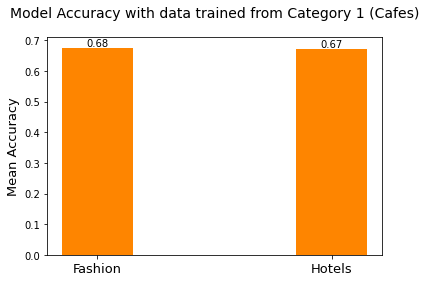

In [0]:
values = [accuracy_1_2,accuracy_1_3]
names = ["Fashion","Hotels"]
plt_acu_1 = plt.bar(names, values, color="#fe8500", width=0.3)
plt.xticks(fontsize=13)
plt.ylabel("Mean Accuracy", fontsize=13)
plt.title("Model Accuracy with data trained from Category 1 (Cafes)", fontsize=14,pad = 20)
autolabel(plt_acu_1)

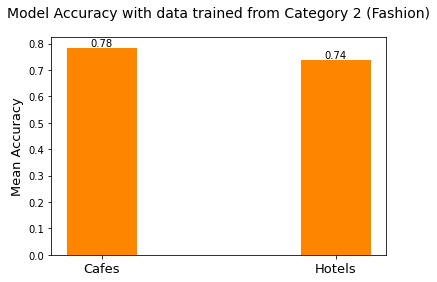

In [0]:
values = [accuracy_2_1,accuracy_2_3]
names = ["Cafes","Hotels"]
plt_acu_2 = plt.bar(names, values, color="#fe8500", width=0.3)
plt.xticks(fontsize=13)
plt.ylabel("Mean Accuracy", fontsize=13)
plt.title("Model Accuracy with data trained from Category 2 (Fashion)", fontsize=14, pad=20)
autolabel(plt_acu_2)

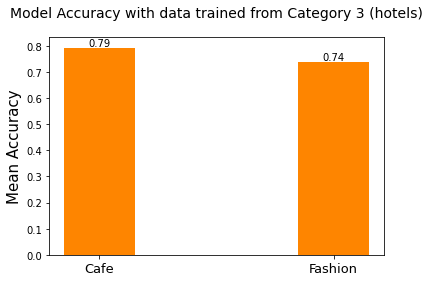

In [0]:
values = [accuracy_3_1,accuracy_3_2]
names = ["Cafe","Fashion"]
plt_acu_3 = plt.bar(names, values, color="#fe8500", width=0.3)
plt.xticks(fontsize=13)
plt.ylabel("Mean Accuracy", fontsize=15)
plt.title("Model Accuracy with data trained from Category 3 (hotels)", fontsize=14,pad = 20)
autolabel(plt_acu_3)

From all the above visualisations for accuracy of models we see that all the models have the accuracy nearly in the same range. But since our data is skewed towards positive class which can be seen in 'support' of classification reports which is the true class label, it would be appropriate to consider the f1 scores for a better comparison.

### Comparing the Macro average of f1 score of all the above three models for task 3  

I am considering macro average of f1 scores sinces it calculates the score separated by each class and does not use weights during aggregation, this is better for comparison because it results in a higher penalisation when the model does not perform well with minority class, which here is 'Negative'.

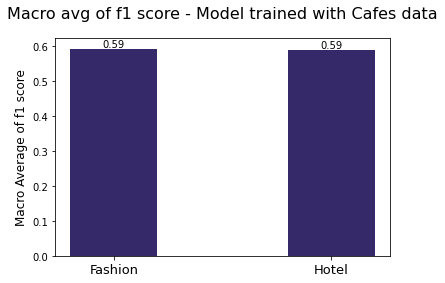

In [0]:
macro_f1_1_2 = report_1_2['macro avg']['f1-score']
macro_f1_1_3 = report_1_3['macro avg']['f1-score']
values = [macro_f1_1_2, macro_f1_1_3]
names = ["Fashion","Hotel"]
plt_f1_cat_1 = plt.bar(names, values, color="#352969", width=0.4)
plt.xticks(fontsize=13)
plt.ylabel("Macro Average of f1 score", fontsize=12)
plt.title("Macro avg of f1 score - Model trained with Cafes data", fontsize=16,pad =20)
autolabel(plt_f1_cat_1)

From the above visualisation we can see prediction for Fashion and hotel data on model trained on Cafes data, have the same performance.

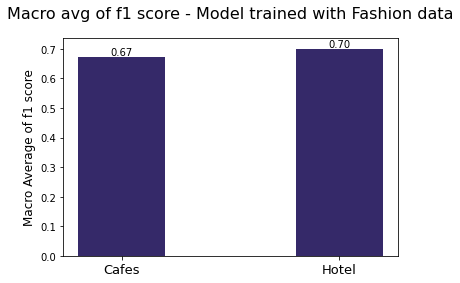

In [0]:
macro_f1_2_1 = report_2_1['macro avg']['f1-score']
macro_f1_2_3 = report_2_3['macro avg']['f1-score']
values = [macro_f1_2_1, macro_f1_2_3]
names = ["Cafes","Hotel"]
plt_f1_cat_2 = plt.bar(names, values, color="#352969", width=0.4)
plt.xticks(fontsize=13)
plt.ylabel("Macro Average of f1 score", fontsize=12)
plt.title("Macro avg of f1 score - Model trained with Fashion data", fontsize=16,pad =20)
autolabel(plt_f1_cat_2)

From the above visualisation we can see prediction for Cafes and hotel data on model trained on Fashion data, hotel has a slightly better performance.

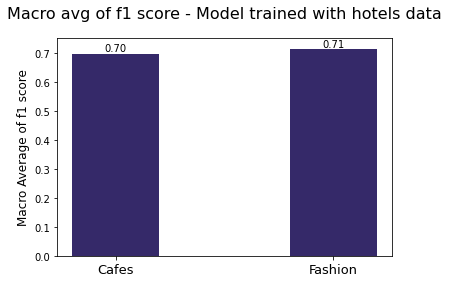

In [0]:
macro_f1_3_1 = report_3_1['macro avg']['f1-score']
macro_f1_3_2 = report_3_2['macro avg']['f1-score']
values = [macro_f1_3_1, macro_f1_3_2]
names = ["Cafes","Fashion"]
plt_f1_cat_3 = plt.bar(names, values, color="#352969", width=0.4)
plt.xticks(fontsize=13)
plt.ylabel("Macro Average of f1 score", fontsize=12)
plt.title("Macro avg of f1 score - Model trained with hotels data", fontsize=16,pad =20)
autolabel(plt_f1_cat_3)

From the above visualisation we can see prediction for Cafes and Fashion data on model trained on hotels data, fashion has a very slight better performance.

## **Conclusion**

<p>Considering the accuracy and f1 scores of all the above classification models built, they dont perform very well by its satisfactory. We can further explore different classification models to see if they they perform better than naive bayes.<p/>
<p>From all the above analysis we also see that though reviews might differ for all the categories and might have words specific to each categories, it is possible to predict the reviews classes for all the different categories. The reason for this would be by considering ngram, if we see the analysis of words done initially which has the top 10 frequented words, we can see 'highly recommend',  'customer service ', 'staff friendly' words falls in top 10 of all the categories. In the same analysis represented by the wordcloud which considers frequented individual words, the words vary for all the categories. </p>
<p>Hence text pre-processing done while building a classification model plays a very important role, and the trial and error of the parameters like ngram and min_df can make significant changes in the accuracy of the model.</p>